# 2D Model Chamber

This notebook implements a 2D extension of the 1D reaction-diffusion model, simulating chamber dynamics, using checkerboard or striped patterns.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from numba import njit
import pickle
import seaborn as sns
from scipy.integrate import trapezoid

# =============================== Units ===============================
# Lengths: micrometers (μm); Time: hours (h)
# Diffusion D: μm^2/h
# Production S: conc/h  (source in producer regions)
# Uptake C: 1/h         (proportional sink in consumer regions)

# --------------------------- Survival model --------------------------
@njit(cache=True, fastmath=True, nogil=True)
def inv_logit(z):
    return 1.0 / (1.0 + np.exp(-z))


@njit(cache=True, fastmath=True, nogil=True)
def predict_survival(RHL, HQNO, m_rhl, m_hqno, b):
    """Survival = σ(m_rhl * RHL + m_hqno * HQNO + b)."""
    return inv_logit(m_rhl * RHL + m_hqno * HQNO + b)


# --------------------------- Simulation config -----------------------
@dataclass
class SimConfig:
    # ----- geometry (μm) -----
    mixed_chamber_mode: str = "chessboard"  # "chessboard" or "stripes"
    L_um: float = 50.0               # channel: length of producer & consumer each
    L_ext_um: float = 3.0           # channel: corridor length
    W_um: float = 50.0               # channel width; chessboard: target box size
    tile_um: float = 10.0            # chessboard: requested tile size (snapped to grid)

    # ----- grid (μm) -----
    dx_um: float = 1.0
    dy_um: float = 1.0

    # ----- physics (HQNO) -----
    D_HQNO_um2_per_s: float = 0.1
    S_HQNO_prod_per_s: float = 0.5
    up_HQNO_cons_per_s: float = 0.02

    # ----- physics (RHL) -----
    D_RHL_um2_per_s: float = 0.05
    S_RHL_prod_per_s: float = 0.2
    up_RHL_cons_per_s: float = 0.01

    # ----- time -----
    t_max_s: float = 1e4
    tol: float = 1e-6
    cfl_safety: float = 0.9
    max_steps: int = int(1e7)

    # ----- channel-only: reflecting strips in diffusion corridor -----
    use_reflecting_strips: bool = True
    strip_width_um: float = 3
    stripes_per_seight: int = 10

    # ----- survival parameters (loaded from JSON) -----
    m_rhl: float = 0.05
    m_hqno: float = -0.03
    b: float = 0.0
    compute_survival: bool = True

    # ----- numerics/IO -----
    use_float32: bool = True
    verbose: bool = True
    make_plots: bool = True

# ----------------------------- Utilities -----------------------------
def _cfl_dt(dx, dy, Dmax, safety=0.9):
    # Explicit 2-D 5-point stencil:
    # dt <= dx^2 * dy^2 / [ 2 * D * (dx^2 + dy^2) ]
    return safety * (dx*dx * dy*dy) / (2.0 * Dmax * (dx*dx + dy*dy))

@njit(cache=True, fastmath=True, nogil=True)
def _laplacian_channel(R, dx, dy, walls):
    nx: int = R.shape[0]
    ny: int = R.shape[1]
    out = np.zeros_like(R)
    inv_dx2: float = 1.0 / (dx * dx)
    inv_dy2: float = 1.0 / (dy * dy)
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            center = R[i, j]
            if np.isnan(center):
                out[i, j] = np.nan
                continue
            r_right = R[i + 1, j] if not (walls[i + 1, j] or np.isnan(R[i + 1, j])) else center
            r_left = R[i - 1, j] if not (walls[i - 1, j] or np.isnan(R[i - 1, j])) else center
            r_up = R[i, j + 1] if not (walls[i, j + 1] or np.isnan(R[i, j + 1])) else center
            r_down = R[i, j - 1] if not (walls[i, j - 1] or np.isnan(R[i, j - 1])) else center
            out[i, j] = (r_right + r_left - 2.0 * center) * inv_dx2 + (r_up + r_down - 2.0 * center) * inv_dy2
    return out

# --------------------------- Geometry builders ------------------------

def _create_chessboard(nx, ny, ds):
    """Create centered chessboard pattern with square size ds."""
    x = np.arange(nx) - nx // 2
    y = np.arange(ny) - ny // 2
    xx, yy = np.meshgrid(x, y, indexing='ij')
    return ((xx // ds) + (yy // ds)) % 2

def _create_stripes(nx, ny, ds):
    """Create centered horizontal stripes with width ds (running in y-direction), with one stripe centered at y=0."""
    y = np.arange(ny) - ny // 2
    # Offset by ds/2 to center a stripe at y=0, then flip to make centered stripe type 1
    stripes = 1 - ((y + ds//2) // ds) % 2
    return np.tile(stripes[None, :], (nx, 1))


def _channel_mixed(nx, ny, cfg, dx, dy, mode='chessboard'):
    """Build S/k fields, walls and masks for the channel layout."""

    if ny != 51:
        raise ValueError("Mixed channel only implemented for ny = 51")

    S_HQNO = np.zeros((nx, ny), dtype=np.float32)
    k_HQNO = np.zeros((nx, ny), dtype=np.float32)
    S_RHL  = np.zeros((nx, ny), dtype=np.float32)
    k_RHL  = np.zeros((nx, ny), dtype=np.float32)

    prod_end = int(round(cfg.L_um / dx))
    diff_end = int(round((cfg.L_um + cfg.L_ext_um) / dx))
    cons_end = int(round((2*cfg.L_um + cfg.L_ext_um) / dx))

    #set strips at fixed locations for 51 cells in y, to match experiments
    walls = np.zeros((nx, ny), dtype=bool)
    walls[prod_end:diff_end, 0] = 1
    walls[prod_end:diff_end, 2::4] = 1
    walls[prod_end:diff_end, 3::4] = 1
    walls[prod_end:diff_end, 4::4] = 1

    # create chessboard pattern in cell region
    nx_cells = cons_end - diff_end
    ny_cells = ny

    ds = max(1, int(round(cfg.tile_um / dx)))
    if mode == 'chessboard':
        pattern = _create_chessboard(nx_cells, ny_cells, ds)
    elif mode == 'stripes':
        pattern = _create_stripes(nx_cells, ny_cells, ds)
    
    consumer_mask = np.zeros((nx, ny), dtype=bool)
    producer_mask = np.zeros((nx, ny), dtype=bool)
    consumer_mask[diff_end:cons_end, :] = pattern == 1
    producer_mask[diff_end:cons_end, :] = pattern == 0

    S_HQNO[producer_mask] = cfg.S_HQNO_prod_per_s
    S_RHL[producer_mask] = cfg.S_RHL_prod_per_s
    k_HQNO[consumer_mask] = cfg.up_HQNO_cons_per_s
    k_RHL[consumer_mask] = cfg.up_RHL_cons_per_s

    return S_HQNO, k_HQNO, S_RHL, k_RHL, walls, consumer_mask, prod_end, diff_end, cons_end


# --------------------------- Numba time-stepping ----------------------
@njit(cache=True, fastmath=True, nogil=True)
def _time_step_solver(
    HQNO: np.ndarray,
    RHL: np.ndarray,
    S_HQNO: np.ndarray,
    k_HQNO: np.ndarray,
    S_RHL: np.ndarray,
    k_RHL: np.ndarray,
    walls: np.ndarray,
    dx: float,
    dy: float,
    dt: float,
    D1: float,
    D2: float,
    t_max: float,
    tol: float,
    max_steps: int
) -> tuple:
    """
    Time-stepping solver for channel mode with explicit loops.
    Returns: (HQNO, RHL, t, steps)
    """
    nx: int = HQNO.shape[0]
    ny: int = HQNO.shape[1]
    HQNO_new = np.empty_like(HQNO)
    RHL_new = np.empty_like(RHL)
    
    t: float = 0.0
    steps: int = 0
    has_walls: bool = np.any(walls)
    
    while t < t_max and steps < max_steps:
        # Interior Laplacians
        lap_HQNO = _laplacian_channel(HQNO, dx, dy, walls)
        lap_RHL = _laplacian_channel(RHL, dx, dy, walls)
        HQNO_new[:, :] = HQNO
        RHL_new[:, :] = RHL
        
        # Update interior
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                HQNO_new[i, j] = HQNO[i, j] + dt * (
                    D1 * lap_HQNO[i, j] + S_HQNO[i, j] - k_HQNO[i, j] * HQNO[i, j]
                )
                RHL_new[i, j] = RHL[i, j] + dt * (
                    D2 * lap_RHL[i, j] + S_RHL[i, j] - k_RHL[i, j] * RHL[i, j]
                )
        
        # Absorbing at x, reflecting at y
        for j in range(ny):
            HQNO_new[0, j] = 0.0
            HQNO_new[nx - 1, j] = 0.0
            RHL_new[0, j] = 0.0
            RHL_new[nx - 1, j] = 0.0
        for i in range(nx):
            HQNO_new[i, 0] = HQNO_new[i, 1]
            HQNO_new[i, ny - 1] = HQNO_new[i, ny - 2]
            RHL_new[i, 0] = RHL_new[i, 1]
            RHL_new[i, ny - 1] = RHL_new[i, ny - 2]
        if has_walls:
            for i in range(nx):
                for j in range(ny):
                    if walls[i, j]:
                        HQNO_new[i, j] = np.nan
                        RHL_new[i, j] = np.nan
        
        # Convergence check
        diff_h: float = 0.0
        diff_r: float = 0.0
        for i in range(nx):
            for j in range(ny):
                d_h = abs(HQNO_new[i, j] - HQNO[i, j])
                d_r = abs(RHL_new[i, j] - RHL[i, j])
                if not np.isnan(d_h) and d_h > diff_h:
                    diff_h = d_h
                if not np.isnan(d_r) and d_r > diff_r:
                    diff_r = d_r
        
        diff: float = max(diff_h, diff_r)
        
        # Swap arrays
        HQNO, HQNO_new = HQNO_new, HQNO
        RHL, RHL_new = RHL_new, RHL
        
        t += dt
        steps += 1
        
        if diff < tol:
            break
    
    return (HQNO, RHL, t, steps)


# -------------------------------- Solver ------------------------------
def run_simulation(cfg: SimConfig):
    dx, dy = cfg.dx_um, cfg.dy_um

    # Domain & grid
    Lx = 2*cfg.L_um + cfg.L_ext_um
    Ly = cfg.W_um
    nx = int(round(Lx / dx)) + 1   # bounded: include end nodes
    ny = int(round(Ly / dy)) + 1

    dtype = np.float32 if cfg.use_float32 else np.float64
    HQNO = np.zeros((nx, ny), dtype=dtype)
    RHL  = np.zeros((nx, ny), dtype=dtype)

    S_HQNO, k_HQNO, S_RHL, k_RHL, walls, consumer_mask, prod_end, diff_end, cons_end = _channel_mixed(nx, ny, cfg, dx, dy, mode=cfg.mixed_chamber_mode)
 
    # Mark walls as NaN for plotting only
    if walls.any():
        HQNO[walls] = np.nan
        RHL[walls]  = np.nan

    # Time step from the largest diffusion
    D1, D2 = cfg.D_HQNO_um2_per_s, cfg.D_RHL_um2_per_s
    dt = _cfl_dt(dx, dy, max(D1, D2), cfg.cfl_safety)

    # --------- Time stepping ---------
    HQNO, RHL, t, steps = _time_step_solver(
        HQNO, RHL, S_HQNO, k_HQNO, S_RHL, k_RHL, walls,
        dx, dy, dt, D1, D2, cfg.t_max_s, cfg.tol, cfg.max_steps
    )

    if cfg.verbose:
        print(f"Finished at t={t:.3g} h after {steps} steps")

    # --------- Residuals for sanity ---------

    lap_HQNO = _laplacian_channel(HQNO, dx, dy, walls)
    lap_RHL  = _laplacian_channel(RHL,  dx, dy, walls)
    res_HQNO = D1*lap_HQNO + S_HQNO - k_HQNO*HQNO
    res_RHL  = D2*lap_RHL  + S_RHL  - k_RHL *RHL
    max_res_HQNO = float(np.nanmax(np.abs(res_HQNO)))
    max_res_RHL  = float(np.nanmax(np.abs(res_RHL)))

    # --------- Survival (consumers only) ---------
    survival_map = None
    survival_stats = None
    if cfg.compute_survival:
        surv_full = predict_survival(RHL, HQNO, cfg.m_rhl, cfg.m_hqno, cfg.b)
        survival_map = np.full_like(surv_full, np.nan, dtype=float)
        survival_map[consumer_mask] = surv_full[consumer_mask]
        survival_stats = {
            "mean": float(np.nanmean(survival_map)),
            "median": float(np.nanmedian(survival_map)),
            "min": float(np.nanmin(survival_map)),
            "max": float(np.nanmax(survival_map)),
        }

    info = {
        "t_s": t, "steps": steps, "dt_s": dt,
        "nx": nx, "ny": ny, "dx_um": dx, "dy_um": dy,
        "max_residual_HQNO": max_res_HQNO, "max_residual_RHL": max_res_RHL,
        "survival_stats": survival_stats
    }
    return (HQNO, RHL, survival_map), info

# ------------------------------ 2D maps ------------------------------
def plot_field_maps(HQNO, RHL, SURV, extent, mode_title=""):

    y_mid = np.round(HQNO.shape[1]/2).astype(int)

    fig1, axes1 = plt.subplots(1, 2, figsize=(10,3))
    im1 = axes1[0].imshow(np.where(np.isnan(HQNO), np.nan, HQNO).T, origin='lower',
                          extent=extent, cmap='inferno', aspect='auto',
                          vmin=0, vmax=np.nanmax(HQNO))
    fig1.colorbar(im1, ax=axes1[0], label="HQNO [arb.]")
    axes1[0].set_xlabel("x [μm]"); axes1[0].set_ylabel("y [μm]")
    axes1[0].set_title(f"HQNO {mode_title}")
    axes1[0].set_aspect('equal', adjustable='box')

    x_vals = np.linspace(extent[0], extent[1], HQNO.shape[0], endpoint=("periodic" not in mode_title))
    axes1[1].plot(x_vals, np.nanmean(HQNO, axis=1), lw=2)
    axes1[1].set_ylim(0, 1.1*np.nanmax(HQNO[:]))
    axes1[1].set_xlabel("x [μm]"); axes1[1].set_ylabel("⟨HQNO⟩_y [arb.]")
    axes1[1].grid(True); axes1[1].set_title("HQNO: ⟨concentration⟩ profile along x at center y")
    plt.tight_layout()

    fig2, axes2 = plt.subplots(1, 2, figsize=(10,3))
    im2 = axes2[0].imshow(np.where(np.isnan(RHL), np.nan, RHL).T, origin='lower',
                          extent=extent, cmap='inferno', aspect='auto',
                          vmin=0, vmax=np.nanmax(RHL))
    fig2.colorbar(im2, ax=axes2[0], label="RHL [arb.]")
    axes2[0].set_xlabel("x [μm]"); axes2[0].set_ylabel("y [μm]")
    axes2[0].set_title(f"RHL {mode_title}")
    axes2[0].set_aspect('equal', adjustable='box')

    axes2[1].plot(x_vals, np.nanmean(RHL, axis=1), lw=2)
    axes2[1].set_ylim(0, 1.1*np.nanmax(RHL[:]))
    axes2[1].set_xlabel("x [μm]"); axes2[1].set_ylabel("⟨RHL⟩_y [arb.]")
    axes2[1].grid(True); axes2[1].set_title("RHL: ⟨concentration⟩ profile along x at center y")
    plt.tight_layout()

    if SURV is not None:
        fig3, ax3 = plt.subplots(1, 2, figsize=(10,3))
        im3 = ax3[0].imshow(SURV.T, origin='lower', extent=extent,
                         cmap='viridis', aspect='auto', vmin=0)
        fig3.colorbar(im3, ax=ax3[0], label="Survival (consumers)")
        ax3[0].set_xlabel("x [μm]"); ax3[0].set_ylabel("y [μm]")
        ax3[0].set_title(f"Predicted survival {mode_title}")
        ax3[0].set_aspect('equal', adjustable='box')


        ax3[1].plot(x_vals, np.nanmean(SURV, axis=1), lw=2)
        ax3[1].set_xlim(extent[0], extent[1])
        ax3[1].set_ylim(0, 1.1*np.nanmax(SURV[:]))
        ax3[1].set_xlabel("x [μm]"); ax3[1].set_ylabel("⟨Survival⟩_y")
        ax3[1].grid(True); ax3[1].set_title("Survival: ⟨value⟩ profile along x at center y")    
        plt.tight_layout()

    plt.show()

# ------------------------ Line-cut with logit survival ------------------------
def plot_linecut_x(HQNO, RHL, SURV, cfg: SimConfig, y_um: float = 60.0,
                   surv_eps: float = 1e-6):
    """
    Left axis: HQNO & RHL (linear). Right axis: Survival (logit scale on (0,1)).
    """
    dx, dy = float(cfg.dx_um), float(cfg.dy_um)
    nx, ny = HQNO.shape

    if cfg.mode == "channel":
        Lx = (nx - 1) * dx
        Ly = (ny - 1) * dy
        j = int(round(y_um / dy))
        j = max(0, min(ny - 1, j))
        x = np.linspace(0.0, Lx, nx, endpoint=True)
        extent = [0, Lx, 0, Ly]
        mode_title = "(channel)"
    elif cfg.mode == "chessboard":
        Lx = nx * dx
        Ly = ny * dy
        y_mod = ((y_um % Ly) + Ly) % Ly
        j = int(round(y_mod / dy)) % ny
        x = np.linspace(0.0, Lx, nx, endpoint=False)
        extent = [0, Lx, 0, Ly]
        mode_title = "(chessboard, periodic)"
    else:
        raise ValueError("cfg.mode must be 'channel' or 'chessboard'")

    hqno_line = HQNO[:, j]
    rhl_line  = RHL[:, j]
    surv_line = SURV[:, j] if SURV is not None else np.full(nx, np.nan)
    surv_plot = np.clip(surv_line, surv_eps, 1.0 - surv_eps)

    fig, axL = plt.subplots(figsize=(9.0, 5.0))
    h1, = axL.plot(x, hqno_line, lw=2, label="HQNO")
    h2, = axL.plot(x, rhl_line,  lw=2, label="RHL")
    axL.set_xlabel("x position (µm)")
    axL.set_ylabel("Concentration [arb.]")
    axL.grid(True, which="both", alpha=0.3)

    axR = axL.twinx()
    h3, = axR.plot(x, surv_plot, lw=2, linestyle="--", label="Survival")
    axR.set_ylabel("Survival")
    axR.set_ylim(bottom=0)

    axL.set_title(f"Line cut at y ≈ {j*dy:.1f} µm {mode_title}")
    lines = [h1, h2, h3]
    labels = [ln.get_label() for ln in lines]
    axL.legend(lines, labels, loc="best")
    fig.tight_layout()
    plt.show()

# main function to calculate segregation scores for point data
def calc_segregation_scores(im, window_sizes):
    '''
    Calculate segregation scores for focal species in image im over specified window sizes.
    
    Parameters:
    -----------
    im : np.ndarray
        2D array with species labels
    window_sizes : list of int
        List of window sizes for calculating segregation scores  
    Returns:
    --------
    mean_segregation : np.ndarray
        Mean segregation scores for each window size
    std_segregation : np.ndarray
        Standard deviation of segregation scores for each window size
    
    '''

    focal_type = 1 # Define index of focal species type
    other_type = 0 # Define index of non-focal species type

    # Calculate global frequency of focal species
    N_focal_G = np.sum(im == focal_type)
    N_other_G = np.sum(im == other_type)

    # Loop over all cells to calculate segregation scores
    nx, ny = im.shape
    segregation_scores = []
    for i in range(nx):
        for j in range(ny):
            if im[i,j] == focal_type:
                segregation_cell = np.empty(len(window_sizes))
                for idx, window_size in enumerate(window_sizes):
                    x0 = max(0, i - window_size)
                    x1 = min(nx, i + window_size + 1)
                    y0 = max(0, j - window_size)
                    y1 = min(ny, j + window_size + 1)

                    # calculate segregation score of focal cell
                    local_window = im[x0:x1, y0:y1]
                    N_focal_L = np.sum(local_window == focal_type) 
                    N_other_L  = np.sum(local_window == other_type)

                    if N_focal_L == 0 and N_other_L == 0:
                        seg_cell = np.nan
                    else:
                        seg_cell = np.abs(N_focal_L/N_focal_G - N_other_L/N_other_G) / (N_focal_L/N_focal_G + N_other_L/N_other_G)

                    # calculate segregation score of focal cell
                    segregation_cell[idx] = seg_cell

                segregation_scores.append(segregation_cell)

    # Compute mean and std of segregation scores
    segregation_scores = np.array(segregation_scores)
    mean_segregation = np.mean(segregation_scores, axis=0)
    std_segregation = np.std(segregation_scores, axis=0)

    non_nan_indices = ~np.isnan(mean_segregation)
    mean_segregation_nn = mean_segregation[non_nan_indices]
    window_sizes_nn = window_sizes[non_nan_indices]
    area = trapezoid(mean_segregation_nn, window_sizes_nn)
    # Calculate multiscale spatial segregation level
    MMSL = area / (window_sizes_nn[-1] - window_sizes_nn[0])


    return (MMSL, mean_segregation, std_segregation)


## Single Run for plotting

Multiscale spatial segregation level (MSSL): 0.4547


/var/folders/bt/bfw962p91rjdg_tcsz3dh95w0000gn/T/ipykernel_95328/2696378857.py:369: RuntimeWarning: Mean of empty slice
  ax3[1].plot(x_vals, np.nanmean(SURV, axis=1), lw=2)


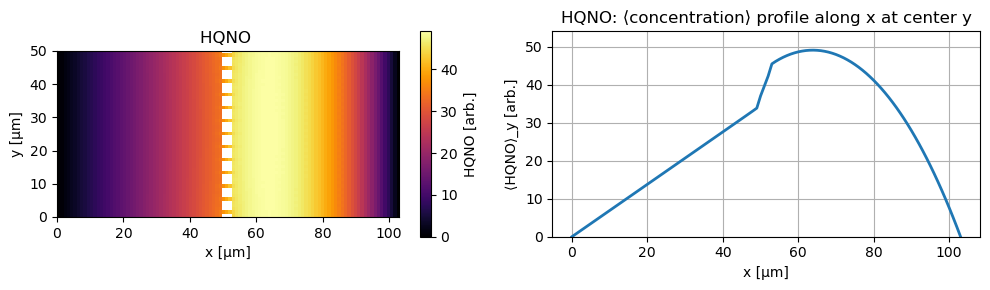

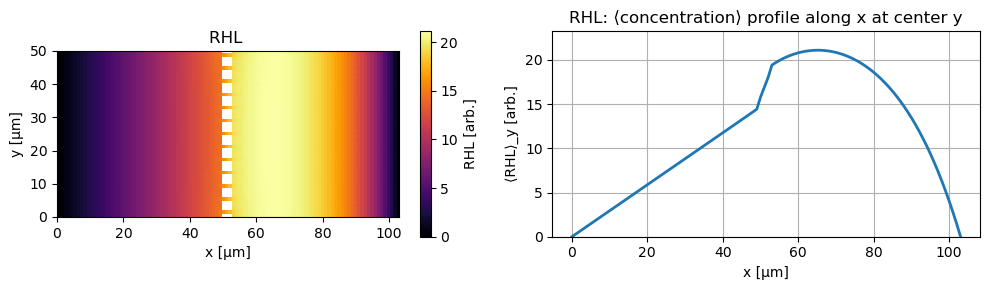

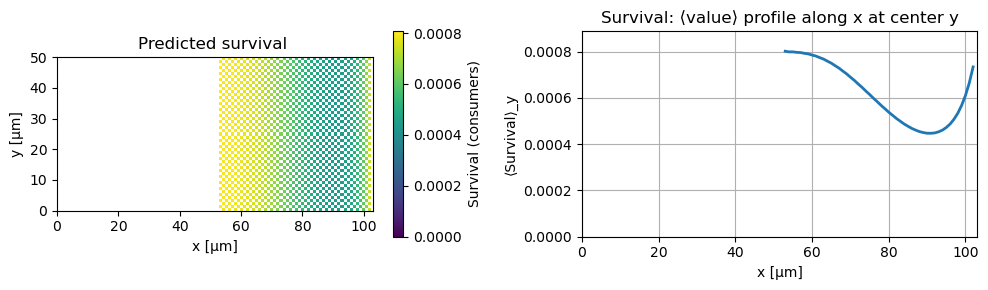

In [2]:

# Load survival parameters from JSON
SURVIVAL_JSON = Path.cwd().parent / '3_batch_survival' / 'data' / 'survival_model_parameters.json'
# Load parameters of fitted survival models
with open(SURVIVAL_JSON, "r", encoding="utf-8") as f:
    logit_model = json.load(f)
# use parameters of the 'hqno_max_60' model as this fits the empirical concentration ranges best
model_params = logit_model['hqno_max_60']['parameters']

# Load model parameters
parameter_CSV = Path.cwd().parent / '4_1D_model' / 'data' / '3_full_model_parameters.csv'
df = pd.read_csv(parameter_CSV)
cols = ['uptake rate', 'production rate', 'Deff']

# get quantiles of production rates
quantiles = [0.25, 0.5, 0.75]
df_h = df[df['molecule'] == 'HQNO'][cols].quantile(quantiles)
df_r = df[df['molecule'] == 'RHL'][cols].quantile(quantiles)

# Vary cluster size in chessboard and stripes mode
spacing = 1
mode = "chessboard"  # "chessboard" or "stripes"
q = 0.5  # quantile for production rate

# Configure 2d model, set prodcution rates using quantiles, use central estimates for other parameters
cfg = SimConfig(
    mixed_chamber_mode=mode,
    tile_um=spacing,
    dx_um=1.0, dy_um=1.0,
    D_HQNO_um2_per_s=df_h.at[0.5, 'Deff'],
    S_HQNO_prod_per_s=df_h.at[q, 'production rate'],
    up_HQNO_cons_per_s=df_h.at[0.5, 'uptake rate'],
    D_RHL_um2_per_s=df_r.at[0.5, 'Deff'],
    S_RHL_prod_per_s=df_r.at[q, 'production rate'],
    up_RHL_cons_per_s=df_r.at[0.5, 'uptake rate'],
    compute_survival=True,
    make_plots=False, verbose=False,
    m_rhl = model_params["m_rhl"],
    m_hqno = model_params["m_hqno"],
    b = model_params["b"]
)

Lx = 2*cfg.L_um + cfg.L_ext_um
Ly = cfg.W_um
extent = [0, Lx, 0, Ly]

(HQNO, RHL, SURV), info = run_simulation(cfg)

pattern = 1 - np.isnan(SURV).astype(int)
MSSL, mean_segr, std_segr = calc_segregation_scores(pattern, window_sizes=np.arange(1, 26))

print(f"Multiscale spatial segregation level (MSSL): {MSSL:.4f}")
plot_field_maps(HQNO, RHL, SURV, extent)


In [3]:


# Load survival parameters from JSON
SURVIVAL_JSON = Path.cwd().parent / '3_batch_survival' / 'data' / 'survival_model_parameters.json'
# Load parameters of fitted survival models
with open(SURVIVAL_JSON, "r", encoding="utf-8") as f:
    logit_model = json.load(f)
# use parameters of the 'hqno_max_60' model as this fits the empirical concentration ranges best
model_params = logit_model['hqno_max_60']['parameters']

# Load model parameters
parameter_CSV = Path.cwd().parent / '4_1D_model' / 'data' / '3_full_model_parameters.csv'
df = pd.read_csv(parameter_CSV)
cols = ['uptake rate', 'production rate', 'Deff']

# get quantiles of production rates
df_h = df[df['molecule'] == 'HQNO'][cols].quantile(0.5)
df_r = df[df['molecule'] == 'RHL'][cols].quantile(0.5)

# Vary cluster size in chessboard and stripes mode
spacing = np.arange(1,27)
mode = ["chessboard"]
output = []

for s in spacing:
    for m in mode: 
       
        # Configure 2d model, using central estimates for all parameters
        cfg = SimConfig(
            mixed_chamber_mode=m,
            tile_um=s,
            dx_um=1.0, dy_um=1.0,
            D_HQNO_um2_per_s=df_h['Deff'],
            S_HQNO_prod_per_s=df_h['production rate'],
            up_HQNO_cons_per_s=df_h['uptake rate'],
            D_RHL_um2_per_s=df_r['Deff'],
            S_RHL_prod_per_s=df_r['production rate'],
            up_RHL_cons_per_s=df_r['uptake rate'],
            compute_survival=True,
            make_plots=False, verbose=False,
            m_rhl = model_params["m_rhl"],
            m_hqno = model_params["m_hqno"],
            b = model_params["b"]
        )
    
        # Run simulation
        (HQNO, RHL, SURV), info = run_simulation(cfg)

        # Calculate segregation scores
        pattern = 1 - np.isnan(SURV).astype(int)
        MSSL, mean_segr, std_segr = calc_segregation_scores(pattern, window_sizes=np.arange(1, 26))
        out = {"mode": m, "cluster size": s, "survival probability": np.nanmean(SURV), "MSSL": MSSL}
        output.append(out)

output_df = pd.DataFrame(output)
output_df.to_csv("./data/cluster_size_vs_survival.csv", index=False)

Spearman correlation:
  ρ = 0.975
  R² = 0.950
  p-value = 3.989e-17


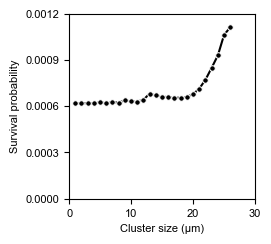

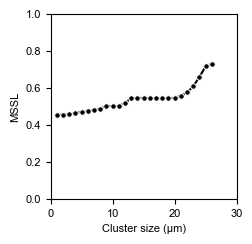

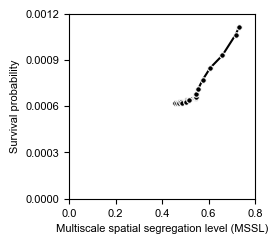

In [4]:
output_df = pd.read_csv("./data/cluster_size_vs_survival.csv")

# -----------------------------
# Plot style
# -----------------------------
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'font.family': 'Arial',
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
    'legend.fontsize': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})


# -----------------------------
# Plot line 
# -----------------------------


fig, ax = plt.subplots(figsize=(6/2.5, 6/2.5))
# df_sub = output_df[output_df['mode'] == 'chessboard']
# sns.lineplot(data=df_sub, x="cluster size", y="survival_q50", marker="o", ax=ax, markersize=4)
sns.lineplot(data=output_df, x="cluster size", y="survival probability", marker="o", ax=ax, color="black", markersize=4, legend=0)
ax.set_xlabel("Cluster size (μm)")
ax.set_ylabel("Survival probability")
ax.set_xlim(0, 30)
ax.set_ylim(0, 0.0012)  # Adjust as needed
ax.set_yticks(np.linspace(0, 0.0012, 5))
plt.savefig("./figures/mixed_chambers_predicted_survival.pdf", bbox_inches='tight')



fig, ax = plt.subplots(figsize=(6/2.5, 6/2.5))
# df_sub = output_df[output_df['mode'] == 'chessboard']
# sns.lineplot(data=df_sub, x="cluster size", y="survival_q50", marker="o", ax=ax, markersize=4)
sns.lineplot(data=output_df, x="cluster size", y="MSSL", marker="o", ax=ax, color="black", markersize=4, legend=0)
ax.set_xlabel("Cluster size (μm)")
ax.set_ylabel("MSSL")
ax.set_xlim(0, 30)
ax.set_ylim(0, 1)  # Adjust as needed
# ax.set_yticks(np.linspace(0, 0.0012, 5))
plt.savefig("./figures/mixed_chambers_MSSL_vs_PatchSize.pdf", bbox_inches='tight')


fig, ax = plt.subplots(figsize=(6/2.5, 6/2.5))
# df_sub = output_df[output_df['mode'] == 'chessboard']
# sns.lineplot(data=df_sub, x="cluster size", y="survival_q50", marker="o", ax=ax, markersize=4)
sns.lineplot(data=output_df, x="MSSL", y="survival probability", marker="o", ax=ax, color="black", markersize=4, legend=0)
ax.set_xlabel("Multiscale spatial segregation level (MSSL)")
ax.set_ylabel("Survival probability")
ax.set_xlim(0, 0.8)
ax.set_ylim(0, 0.0012)  # Adjust as needed
ax.set_yticks(np.linspace(0, 0.0012, 5))
# ax.set_yticks(np.linspace(0, 0.0012, 5))
plt.savefig("./figures/mixed_chambers_predicted_survival_vs_MSSL.pdf", bbox_inches='tight')


# -----------------------------
# Calculate Spearman correlation
# -----------------------------
from scipy.stats import spearmanr
rho, pval = spearmanr(output_df['MSSL'], output_df['survival probability'])
r2 = rho**2

print(f"Spearman correlation:")
print(f"  ρ = {rho:.3f}")
print(f"  R² = {r2:.3f}")
print(f"  p-value = {pval:.4g}")

